## Imports

In [16]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import BinaryCrossentropy
from pyMLaux import show_img_data, plot_history, evaluate_regression_result

import tensorflow_hub as hub

## Load Data

In [2]:
pizza_dir = './data/input/pizza_not_pizza/pizza' 
not_pizza_dir = './data/input/pizza_not_pizza/not_pizza'
data_dir = './data/input/pizza_not_pizza'
test_dir = './data/input/pizza_not_pizza_test'
pizza_test_dir = './data/input/pizza_not_pizza_test/pizza'
not_pizza_test_dir = './data/input/pizza_not_pizza_test/not_pizza'

AI_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\pizza_not_pizza\pizza' 
AI_not_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\pizza_not_pizza\not_pizza'
AI_data_dir = r'C:\Users\jakob\Desktop\COV-AI\pizza_not_pizza'


Improved_AI_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\improved_pizza_not_pizza\pizza' 
Improved_AI_not_pizza_dir = r'C:\Users\jakob\Desktop\COV-AI\imporved_pizza_not_pizza\not_pizza'
Improved_AI_data_dir = r'C:\Users\jakob\Desktop\COV-AI\improved_pizza_not_pizza'



In [3]:
num_pizza_images = len(os.listdir(pizza_dir))
num_non_pizza_images = len(os.listdir(not_pizza_dir))
num_test_pizza = len(os.listdir(pizza_test_dir))
num_test_non_pizza = len(os.listdir(not_pizza_test_dir))

print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {num_non_pizza_images}')
print(f'Number of Pizza test images: {num_test_pizza}')
print(f'Number of Non-Pizza test images: {num_test_non_pizza}')



Number of Pizza images: 908
Number of Non-Pizza images: 908
Number of Pizza test images: 75
Number of Non-Pizza test images: 75


# Original Data

## Train/Validation/Test Data Sets

In [4]:
batch_size = 32

data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = batch_size,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = batch_size,
                                        subset = 'validation',
                                        class_mode = 'binary')
test_data = data_gen.flow_from_directory(test_dir, 
                                         target_size = (224, 224), 
                                         batch_size = batch_size,
                                         class_mode = 'binary')

Found 1454 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


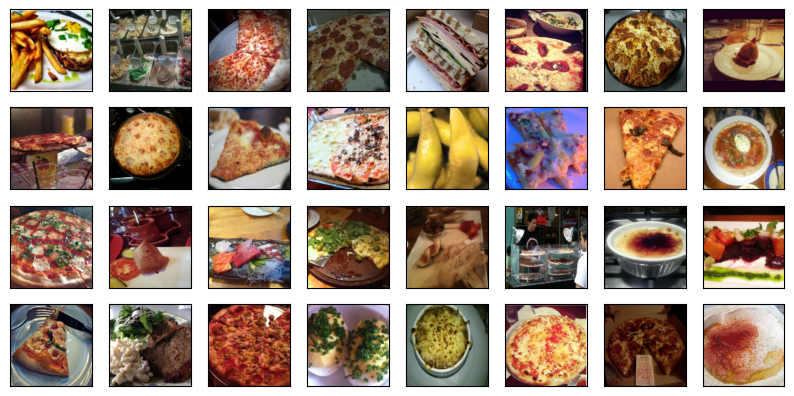

In [5]:
for image_batch, label_batch in train_data:
    show_img_data(image_batch, no=batch_size, layout=(8, 8), figsize=(10, 10))
    
    break



## Baseline Model

In [6]:
tf.random.set_seed(42)
model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer    
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # First Convolutional layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # Second Convolutional layer
    Flatten(),
    Dense(1, activation = 'sigmoid') # Output layer  
])

model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])



## Train Model

In [8]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn1.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)
callbacks_list = [checkpoint]

history_1 = model_1.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data),
                        callbacks=callbacks_list)



Epoch 1/5


46/46 [==============================] - ETA: 0s - loss: 6.8721 - accuracy: 0.5158
Epoch 1: val_accuracy improved from -inf to 0.49448, saving model to ./data/cnn_models\pizza-not-pizza_cnn1.hdf5
46/46 [==============================] - 34s 704ms/step - loss: 6.8721 - accuracy: 0.5158 - val_loss: 0.6930 - val_accuracy: 0.4945
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.5468
Epoch 2: val_accuracy improved from 0.49448 to 0.51657, saving model to ./data/cnn_models\pizza-not-pizza_cnn1.hdf5
46/46 [==============================] - 33s 722ms/step - loss: 0.6749 - accuracy: 0.5468 - val_loss: 0.6817 - val_accuracy: 0.5166
Epoch 3/5
46/46 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.6912
Epoch 3: val_accuracy improved from 0.51657 to 0.60221, saving model to ./data/cnn_models\pizza-not-pizza_cnn1.hdf5
46/46 [==============================] - 32s 700ms/step - loss: 0.5777 - accuracy: 0.6912 - val_loss: 0.6680 -

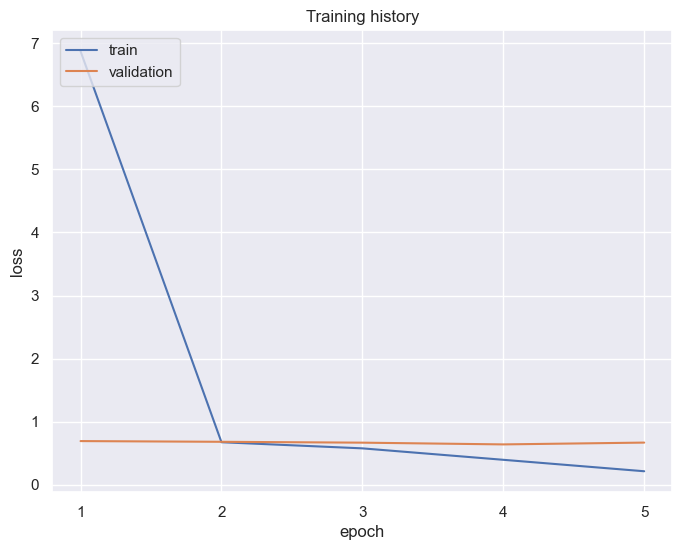

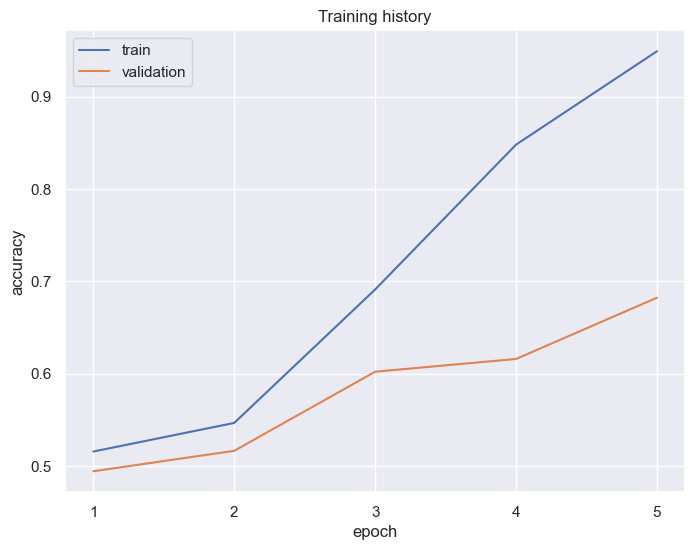

In [9]:
plot_history(history_1)

In [10]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 1s 128ms/step - loss: 0.5994 - accuracy: 0.7067
Test loss: 0.5994453430175781
Test accuracy: 0.7066666483879089


## Improving the Model


    Increasing the number of epochs
    Adding Max Pooling Layer
    Adding more convolutional layers
    Changing the number of filters
    Changing the size of our filters
    Changing the pool size of Max Pooling layer



In [39]:
model_2 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])



In [13]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn2.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)
callbacks_list = [checkpoint]

history_2 = model_2.fit(train_data,
                        epochs= 20,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data),
                        callbacks=callbacks_list)

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.5213
Epoch 1: val_accuracy improved from -inf to 0.62707, saving model to ./data/cnn_models\pizza-not-pizza_cnn2.hdf5
46/46 [==============================] - 11s 226ms/step - loss: 0.6948 - accuracy: 0.5213 - val_loss: 0.6663 - val_accuracy: 0.6271
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.6376
Epoch 2: val_accuracy improved from 0.62707 to 0.68508, saving model to ./data/cnn_models\pizza-not-pizza_cnn2.hdf5
46/46 [==============================] - 10s 222ms/step - loss: 0.6558 - accuracy: 0.6376 - val_loss: 0.6345 - val_accuracy: 0.6851
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.6664
Epoch 3: val_accuracy improved from 0.68508 to 0.72652, saving model to ./data/cnn_models\pizza-not-pizza_cnn2.hdf5
46/46 [==============================] - 10s 226ms/step - loss: 0.6277 - accuracy: 0.6664 - val_loss: 0.6016 

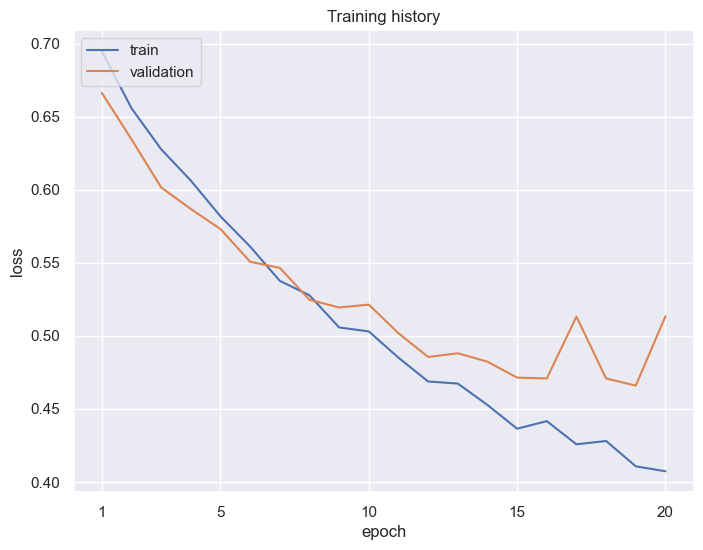

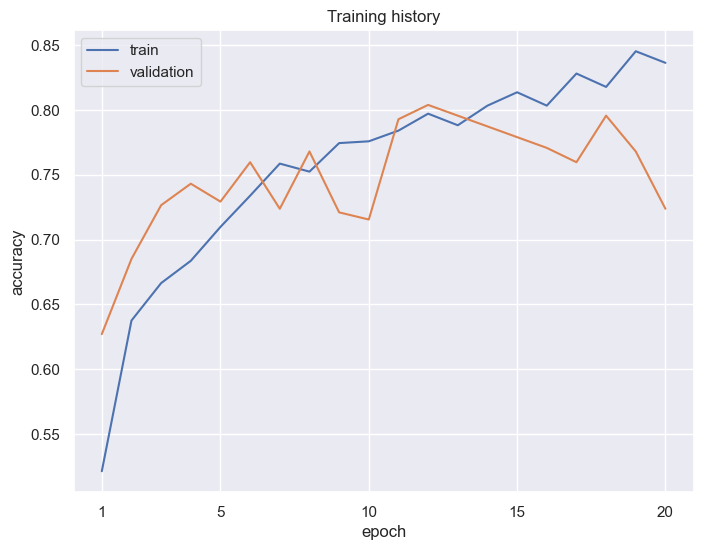

In [14]:
plot_history(history_2)

In [15]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 1s 105ms/step - loss: 0.5300 - accuracy: 0.7400
Test loss: 0.5299704074859619
Test accuracy: 0.7400000095367432


# AI Data

## AI Data Train/Validation Data Sets

In [6]:
AI_num_pizza_images = len(os.listdir(AI_pizza_dir))
AI_non_pizza_images = len(os.listdir(AI_not_pizza_dir))
print(f'Number of Generated Pizza images: {AI_num_pizza_images}')
print(f'Number of Generated Non-Pizza images: {AI_non_pizza_images}')

Number of Generated Pizza images: 1050
Number of Generated Non-Pizza images: 1001


In [7]:
batch_size = 32

data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

AI_train_data = data_gen.flow_from_directory(AI_data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = batch_size,
                                          subset = 'training',
                                          class_mode = 'binary')
AI_val_data = data_gen.flow_from_directory(AI_data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = batch_size,
                                        subset = 'validation',
                                        class_mode = 'binary')


Found 1641 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


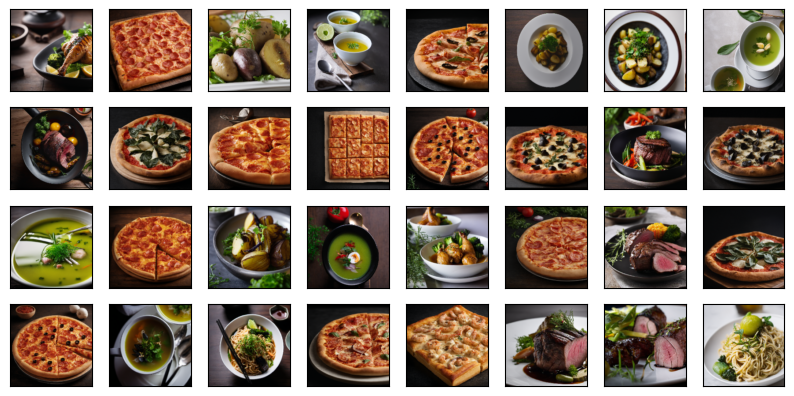

In [8]:
for image_batch, label_batch in AI_train_data:
    show_img_data(image_batch, no=batch_size, layout=(8, 8), figsize=(10, 10))
    
    break



In [40]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_AI.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]


history_3 = model_2.fit(AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(AI_train_data),
                        validation_data = AI_val_data,
                        validation_steps = len(AI_val_data),
                        callbacks=callbacks_list)

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.4915 - accuracy: 0.8282
Epoch 1: val_accuracy improved from -inf to 0.94878, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI.hdf5
52/52 [==============================] - 90s 2s/step - loss: 0.4915 - accuracy: 0.8282 - val_loss: 0.2922 - val_accuracy: 0.9488
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9445
Epoch 2: val_accuracy improved from 0.94878 to 0.97561, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI.hdf5
52/52 [==============================] - 89s 2s/step - loss: 0.2150 - accuracy: 0.9445 - val_loss: 0.1272 - val_accuracy: 0.9756
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9787
Epoch 3: val_accuracy improved from 0.97561 to 0.99024, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI.hdf5
52/52 [==============================] - 88s 2s/step - loss: 0.0996 - accuracy: 0.9787 - val_loss: 0.0605 - v

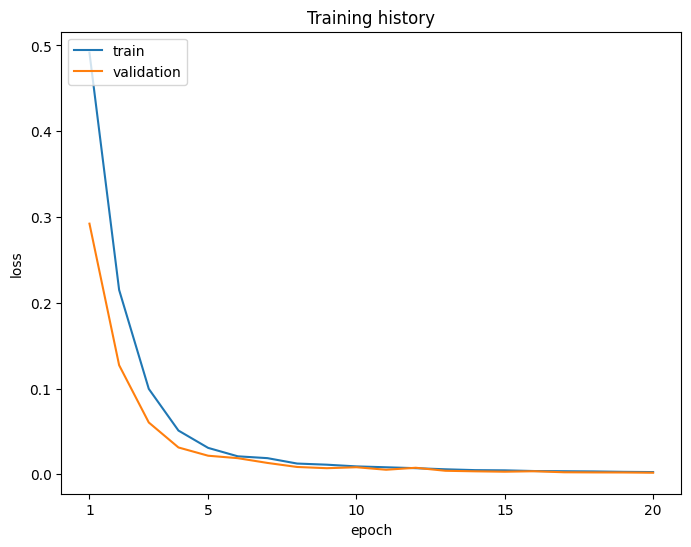

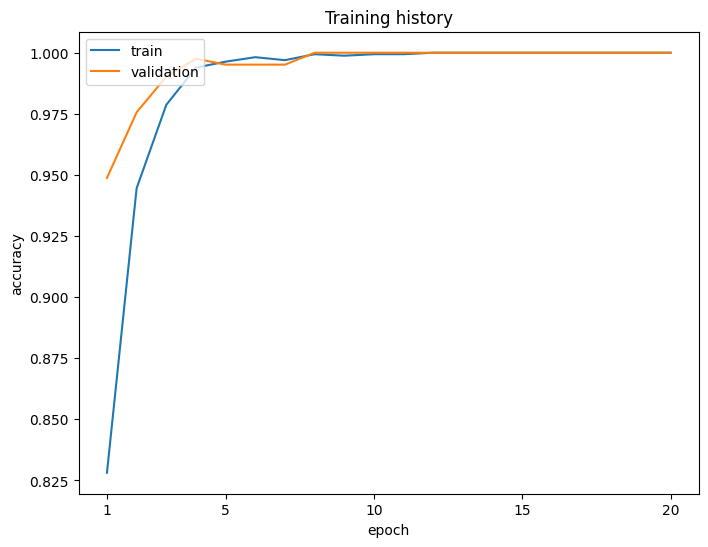

In [41]:
plot_history(history_3)

In [38]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 1s 102ms/step - loss: 1.6180 - accuracy: 0.5733
Test loss: 1.618048906326294
Test accuracy: 0.5733333230018616


### Dropout und L2 Regularisierung

In [42]:
model_3 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 8, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = l2(0.001)),
    MaxPool2D(pool_size = 2),
    Dropout(0.2),
    Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = l2(0.001)),
    MaxPool2D(pool_size = 2),
    Dropout(0.2),
    Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', kernel_regularizer = l2(0.001)),
    MaxPool2D(pool_size = 2),
    Dropout(0.2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_3.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

In [11]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_AI_dropout_l2.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]

history_4 = model_3.fit(AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(AI_train_data),
                        validation_data = AI_val_data,
                        validation_steps = len(AI_val_data),
                        callbacks=callbacks_list)

Epoch 1/20


52/52 [==============================] - ETA: 0s - loss: 0.5894 - accuracy: 0.7038
Epoch 1: val_accuracy improved from -inf to 0.94390, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI_dropout_l2.hdf5
52/52 [==============================] - 113s 2s/step - loss: 0.5894 - accuracy: 0.7038 - val_loss: 0.5277 - val_accuracy: 0.9439
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.9470
Epoch 2: val_accuracy improved from 0.94390 to 0.97561, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI_dropout_l2.hdf5
52/52 [==============================] - 79s 2s/step - loss: 0.2738 - accuracy: 0.9470 - val_loss: 0.2565 - val_accuracy: 0.9756
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9768
Epoch 3: val_accuracy improved from 0.97561 to 0.99512, saving model to ./data/cnn_models\pizza-not-pizza_cnn_AI_dropout_l2.hdf5
52/52 [==============================] - 78s 1s/step - loss: 0.1281 - acc

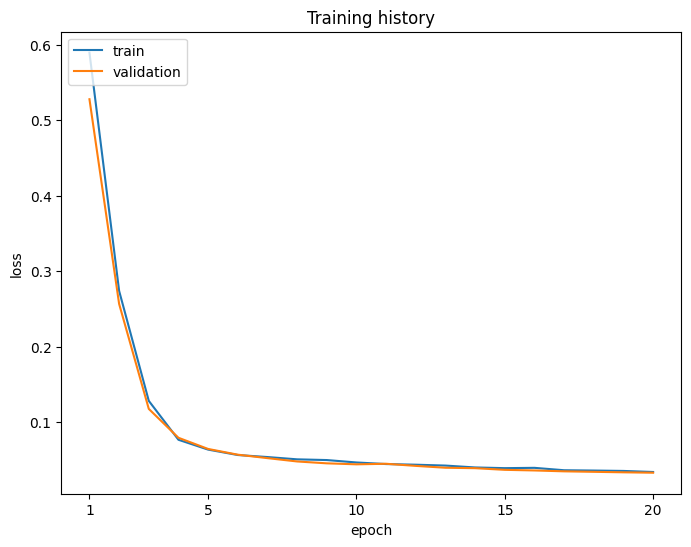

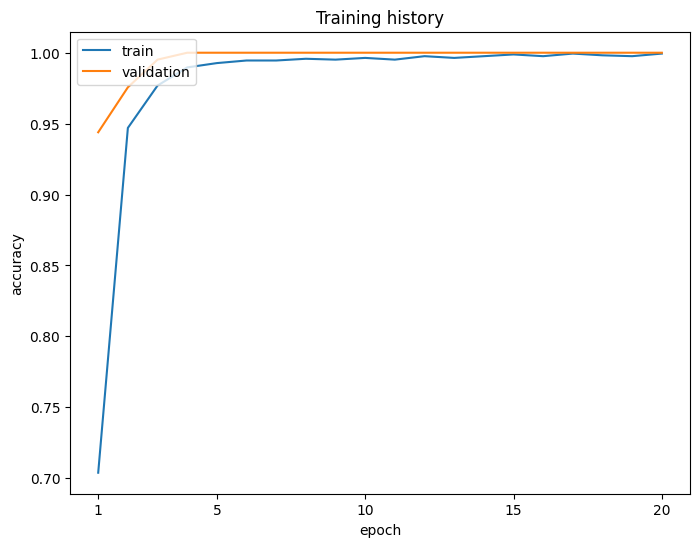

In [43]:
plot_history(history_4)

In [12]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 1s 139ms/step - loss: 1.4006 - accuracy: 0.5533
Test loss: 1.4006205797195435
Test accuracy: 0.5533333420753479


# Improved AI Data

## Improved AI Data Train/Validation Data Sets

In [ ]:
AI_num_pizza_images = len(os.listdir(Improved_AI_pizza_dir))
AI_non_pizza_images = len(os.listdir(Improved_AI_not_pizza_dir))
print(f'Number of Generated Pizza images: {AI_num_pizza_images}')
print(f'Number of Generated Non-Pizza images: {AI_non_pizza_images}')

In [ ]:
batch_size = 32

data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

Improved_AI_train_data = data_gen.flow_from_directory(Improved_AI_data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = batch_size,
                                          subset = 'training',
                                          class_mode = 'binary')
Improved_AI_val_data = data_gen.flow_from_directory(Improved_AI_data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = batch_size,
                                        subset = 'validation',
                                        class_mode = 'binary')


In [ ]:
for image_batch, label_batch in AI_train_data:
    show_img_data(image_batch, no=batch_size, layout=(8, 8), figsize=(10, 10))
    
    break



## model 2

In [ ]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_Improved_AI.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]


history_7 = model_2.fit(Improved_AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(Improved_AI_train_data),
                        validation_data = Improved_AI_val_data,
                        validation_steps = len(Improved_AI_val_data),
                        callbacks=callbacks_list)

In [ ]:
plot_history(history_7)

In [ ]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

## model 2 + Dropout + L2

In [ ]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_Improved_AI_dropout_l2.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]

history_8 = model_3.fit(Improved_AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(Improved_AI_train_data),
                        validation_data = Improved_AI_val_data,
                        validation_steps = len(Improved_AI_val_data),
                        callbacks=callbacks_list)

In [ ]:
plot_history(history_8)

In [ ]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

# Pretrained Model

In [ ]:
base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

base_model.trainable = False

In [ ]:
flat = tf.keras.layers.GlobalAveragePooling2D()(base_model.layers[-1].output)
dense = tf.keras.layers.Dense(256, activation='relu')(flat)
dropout = tf.keras.layers.Dropout(0.5)(dense)
output = tf.keras.layers.Dense(1, activation=None)(dropout)

model_4 = tf.keras.models.Model(inputs=base_model.inputs, outputs=output)

model_4.compile(loss = BinaryCrossentropy(),
              optimizer = Adam(learning_rate = 0.0001),
              metrics = ["accuracy"])

### Original Data

In [32]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_imagenet.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]

history_5 = model_4.fit(train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data),
                        callbacks=callbacks_list)

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 3.5181 - accuracy: 0.6465
Epoch 1: val_accuracy improved from -inf to 0.87569, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet.hdf5
46/46 [==============================] - 24s 468ms/step - loss: 3.5181 - accuracy: 0.6465 - val_loss: 0.7864 - val_accuracy: 0.8757
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 1.5724 - accuracy: 0.8212
Epoch 2: val_accuracy improved from 0.87569 to 0.90331, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet.hdf5
46/46 [==============================] - 21s 453ms/step - loss: 1.5724 - accuracy: 0.8212 - val_loss: 0.7118 - val_accuracy: 0.9033
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 1.0975 - accuracy: 0.8851
Epoch 3: val_accuracy improved from 0.90331 to 0.92541, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet.hdf5
46/46 [==============================] - 21s 463ms/step - loss: 1.0975 - accuracy: 0.

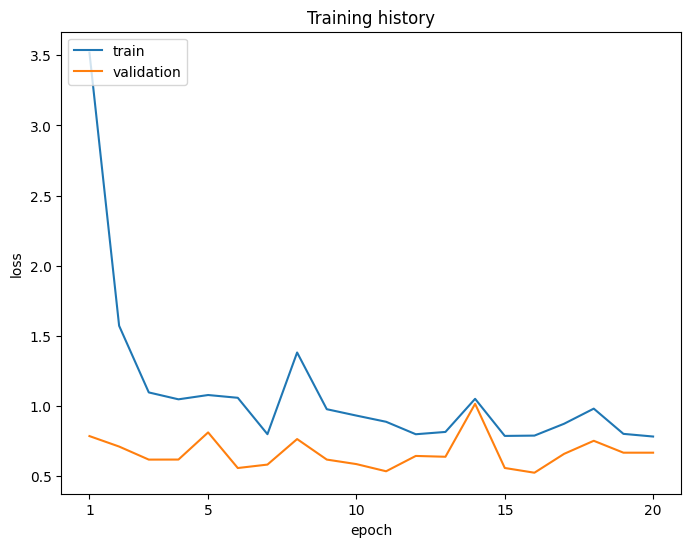

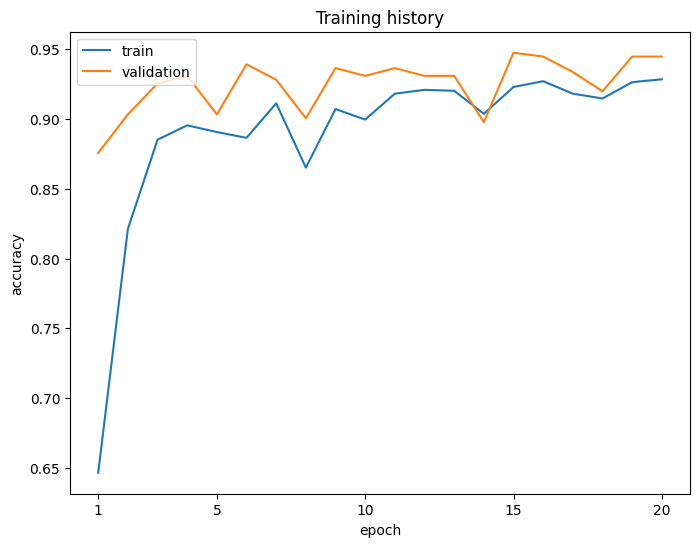

In [37]:
plot_history(history_5)

In [33]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 3s 321ms/step - loss: 0.5660 - accuracy: 0.9400
Test loss: 0.5660422444343567
Test accuracy: 0.9399999976158142


### AI Data

In [34]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_imagenet_AI.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]

history_6 = model_4.fit(AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(AI_train_data),
                        validation_data = AI_val_data,
                        validation_steps = len(AI_val_data),
                        callbacks=callbacks_list)

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9811
Epoch 1: val_accuracy improved from -inf to 0.62707, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet_AI.hdf5
52/52 [==============================] - 66s 1s/step - loss: 0.1302 - accuracy: 0.9811 - val_loss: 0.8773 - val_accuracy: 0.6271
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9982
Epoch 2: val_accuracy improved from 0.62707 to 0.63812, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet_AI.hdf5
52/52 [==============================] - 67s 1s/step - loss: 0.0623 - accuracy: 0.9982 - val_loss: 0.9878 - val_accuracy: 0.6381
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9994
Epoch 3: val_accuracy improved from 0.63812 to 0.64088, saving model to ./data/cnn_models\pizza-not-pizza_cnn_imagenet_AI.hdf5
52/52 [==============================] - 67s 1s/step - loss: 0.0526 - accuracy: 0.

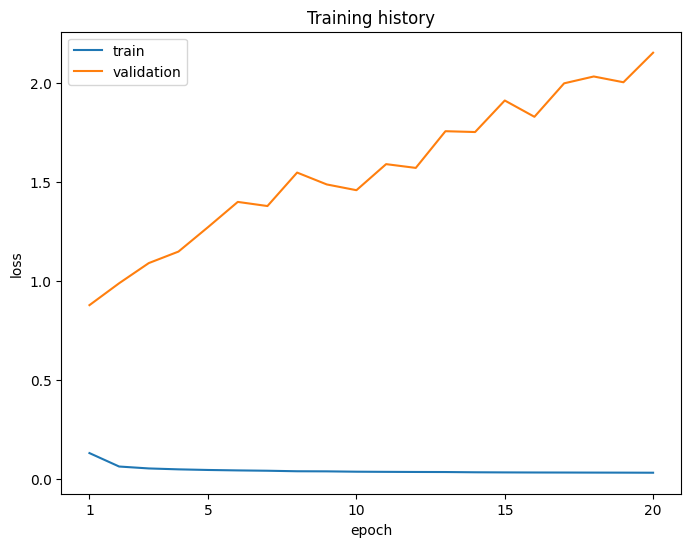

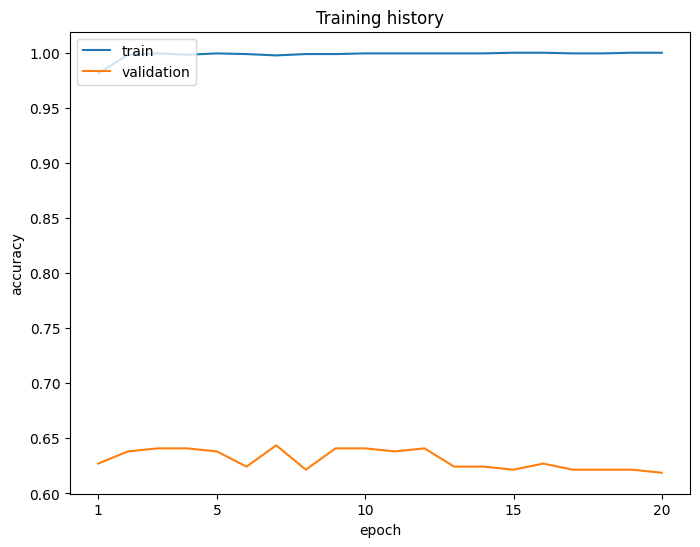

In [36]:
plot_history(history_6)

In [35]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 1s 115ms/step - loss: 1.5715 - accuracy: 0.5933
Test loss: 1.5714503526687622
Test accuracy: 0.5933333039283752


## Improved AI Data

In [ ]:
model_filepath = './data/cnn_models/pizza-not-pizza_cnn_imagenet_Improved_AI.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max', save_weights_only=False)

callbacks_list = [checkpoint]

history_9 = model_4.fit(Improved_AI_train_data, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(Improved_AI_train_data),
                        validation_data = Improved_AI_val_data,
                        validation_steps = len(Improved_AI_val_data),
                        callbacks=callbacks_list)

In [ ]:
plot_history(history_9)

In [ ]:
# Evaluate the model on the test data

model = tf.keras.models.load_model(model_filepath)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")